In [12]:
!apt-get install -y graphviz #installs the Graphviz software
!pip install graphviz   #generate and display trees.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [27]:
import pandas as pd
from graphviz import Digraph, Source  #Digraph:directed graph,source display the graph on colab
from IPython.display import display

**FIND GINI INDEX**

In [14]:
def gini_index(groups, classes, target):
    n_instances = float(sum(len(g) for g in groups))
    if n_instances == 0:
        return 0.0
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        labels = group[target].tolist()
        for class_val in classes:
            p = labels.count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

**SPLIT DATASET BY ATTRIBUTE**

In [15]:
def split_by_attribute(attribute, dataset):
    values = list(dataset[attribute].unique())
    groups = [ dataset[dataset[attribute] == v].reset_index(drop=True) for v in values ]
    return values, groups

**FIND BEST SPLIT**

In [16]:
def get_best_split(dataset, attributes, target):
    class_values = list(dataset[target].unique())
    best_attr = None
    best_gini = float('inf')
    best_values = None
    best_groups = None
    for attr in attributes:
        values, groups = split_by_attribute(attr, dataset)
        g = gini_index(groups, class_values, target)
        if g < best_gini:
            best_gini = g
            best_attr = attr
            best_values = values
            best_groups = groups
    if best_attr is None:
        return None
    return {'attribute': best_attr, 'values': best_values, 'groups': best_groups, 'gini': best_gini}

    # ---- Majority class ----
def majority_class(dataset, target):
    return dataset[target].mode()[0]

**RECURSIVE TREE BUILDER**

In [17]:
def build_tree(dataset, target, attributes=None):
    if attributes is None:
        attributes = [col for col in dataset.columns if col != target]

    # If node is pure
    if len(dataset[target].unique()) == 1:
        return {'leaf': True, 'class': dataset[target].iloc[0], 'samples': len(dataset)}

    # If no attributes left
    if not attributes:
        return {'leaf': True, 'class': majority_class(dataset, target), 'samples': len(dataset)}

    split = get_best_split(dataset, attributes, target)
    if split is None:
        return {'leaf': True, 'class': majority_class(dataset, target), 'samples': len(dataset)}

    node = {
        'leaf': False,
        'attribute': split['attribute'],
        'gini': split['gini'],
        'samples': len(dataset),
        'branches': {}
    }
    for val, group in zip(split['values'], split['groups']):
        if len(group) == 0:
            node['branches'][val] = {'leaf': True, 'class': majority_class(dataset, target), 'samples': 0}
        else:
            remaining_attrs = [a for a in attributes if a != split['attribute']]
            node['branches'][val] = build_tree(group, target, remaining_attrs)
    return node


**VISUALIZATION OF TREE**

In [24]:
def visualize_tree_graphviz(node):
    graph = Digraph()
    counter = {'i':0}
    def add(node):
        nid = f"n{counter['i']}"
        counter['i'] += 1
        if node.get('leaf'):
            label = f"{node['class']}"
            graph.node(nid, label, shape='box', style='filled', color='lightgrey')
        else:
            label = f"{node['attribute']}"
            graph.node(nid, label, shape='ellipse', style='filled', color='lightblue')
            for val, child in node['branches'].items():
                child_id = add(child)
                graph.edge(nid, child_id, label=str(val))
        return nid
    add(node)
    return graph


DATASET 01

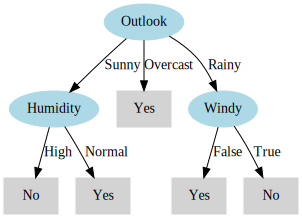

In [25]:
data = pd.DataFrame ({

    'Outlook':    ['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast',
                   'Sunny','Sunny','Rainy','Sunny','Overcast','Overcast','Rainy'],
    'Temperature':['Hot','Hot','Hot','Mild','Cool','Cool','Cool',
                   'Mild','Cool','Mild','Mild','Mild','Hot','Mild'],
    'Humidity':   ['High','High','High','High','Normal','Normal','Normal',
                   'High','Normal','Normal','Normal','High','Normal','High'],
    'Windy':      ['False','True','False','False','False','True','True',
                   'False','False','False','True','True','False','True'],
    'PlayTennis': ['No','No','Yes','Yes','Yes','No','Yes',
                   'No','Yes','Yes','Yes','Yes','Yes','No']
})

target_col = "PlayTennis"
tree = build_tree(data, target=target_col)
#print_tree(tree)

graph = visualize_tree_graphviz(tree)
display(Source(graph.source))

DATASET02

[Income] (gini=0.133, samples=10)
  └─ High:
      → Yes (samples=3)
  └─ Medium:
      [CreditScore] (gini=0.0, samples=3)
        └─ Fair:
            → Yes (samples=2)
        └─ Low:
            → No (samples=1)
  └─ Low:
      → No (samples=4)


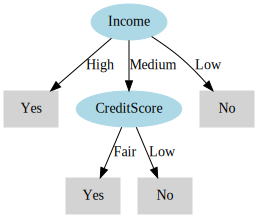

In [26]:
data = pd.DataFrame({

    'CreditScore': ['High','High','Fair','Fair','Low','Low','Fair','High','Low','Fair'],
    'Income':      ['High','High','Medium','Low','Low','Medium','Medium','Low','Low','High'],
    'Collateral':  ['Good','None','Good','None','Good','None','None','Good','None','Good'],
    'LoanApproved':['Yes','Yes','Yes','No','No','No','Yes','No','No','Yes']
})


target_col = "LoanApproved"
tree = build_tree(data, target=target_col)
print_tree(tree)

graph = visualize_tree_graphviz(tree)
display(Source(graph.source))